# **Time Series Prediction with LSTM Using PyTorch**

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

## Reference
- https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

## **Download Dataset**

In [ ]:
data_path = 'timeline_diagnosed.csv'

## **Import Packages**

In [ ]:
# For data preprocess
import os
import csv
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Pytorch
import torch
import torch.nn as nn
from torch.autograd import Variable

## **Set Random Seed**

In [ ]:
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## **Get GPU Resource**

In [ ]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cpu


## **Setup Hyper-parameters**

In [ ]:
# data selection
seq_length = 7  # X(seq_length) + Y(1)

start_date = "2022-03-10"
end_date   = "2022-06-01"
delta_date = datetime.strptime(end_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")
data_size = delta_date.days + 1 - seq_length
print(data_size)
test_size = 3
train_size = data_size - test_size
test_start_date = (pd.to_datetime(end_date) + pd.DateOffset(days=(-test_size+1))).strftime("%Y-%m-%d")
start_date_y = (pd.to_datetime(start_date) + pd.DateOffset(days=(seq_length))).strftime("%Y-%m-%d")

pred_long_size = 14

city_codes = ["KEE", "NWT", "TPE", "TAO", "HSZ", "HSQ", "MIA", "TXG", "CHA", "NAN", "YUN", "CYQ", "CYI", "TNN", "KHH", "PIF", "ILA", "HUA", "TTT", "PEN", "KIN", "LIE"]
# city_codes = ["NWT", "TPE", "TXG", "KHH", "TTT", "PEN"]

# model parameters
num_epochs = 12000
early_stop = 4000
learning_rate = 0.01

input_size = 1
hidden_size = 3
num_layers = 1
num_classes = 1

criterion = torch.nn.MSELoss()    # mean-squared error for regression
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# save model
os.makedirs('models', exist_ok=True)
save_path = "models/model-{}.pth"

# others
seed = 20220605

77


## **Check Raw Data**

In [ ]:
dataset = pd.read_csv(data_path)
print(dataset)

      city        date  count  accumulateCount
0      KEE  2020-01-28      0                0
1      NWT  2020-01-28      0                0
2      TPE  2020-01-28      0                0
3      TAO  2020-01-28      0                0
4      HSZ  2020-01-28      0                0
...    ...         ...    ...              ...
19821  TTT  2022-06-07    933            19838
19822  PEN  2022-06-07    314             4353
19823  KIN  2022-06-07     99             3191
19824  LIE  2022-06-07     57              843
19825   TW  2022-06-07  80184          2606905

[19826 rows x 4 columns]


In [ ]:
def get_city_data(dataset, city):
    mask = ((dataset["city"] == city) & (dataset["date"] >= start_date) & (dataset["date"] <= end_date))
    city_dataset = dataset[mask]["count"].values.reshape(-1, 1)
    # print(city_dataset)

    # plt.plot(city_dataset, label = 'COVID-19 New Cases')
    # plt.show()
    return city_dataset

## **Preprocessing**

In [ ]:
def data_preprocess(city_dataset):
    def sliding_windows(data, seq_length):
        x = []
        y = []

        for i in range(data_size):
            _x = data[i:(i+seq_length)]
            _y = data[i+seq_length]
            x.append(_x)
            y.append(_y)

        return np.array(x),np.array(y)

    sc = MinMaxScaler()
    city_data = sc.fit_transform(city_dataset)
    x, y = sliding_windows(city_data, seq_length)

    dataX = Variable(torch.Tensor(np.array(x)))
    dataY = Variable(torch.Tensor(np.array(y)))

    train_indices = [i for i in range(train_size) if i%10 != 7]
    val_indices = [i for i in range(train_size) if i%10 == 7]

    trainX = Variable(torch.Tensor(np.array(x[train_indices])))
    trainY = Variable(torch.Tensor(np.array(y[train_indices])))

    valX = Variable(torch.Tensor(np.array(x[val_indices])))
    valY = Variable(torch.Tensor(np.array(y[val_indices])))

    testX = Variable(torch.Tensor(np.array(x[train_size: len(x)])))
    testY = Variable(torch.Tensor(np.array(y[train_size: len(y)])))

    return sc, dataX, dataY, trainX, trainY, valX, valY, testX, testY

## **Model**
LSTM + fully connected layer

In [ ]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size * num_layers, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, 
            x.size(0), 
            self.hidden_size,
            device=device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers,
            x.size(0),
            self.hidden_size,
            device=device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size * self.num_layers)
        
        out = self.fc(h_out)
        
        return out

# **Train/Test**

## **Training**

In [ ]:
def train(city, model, trainX, trainY, valX, valY):
    min_loss = np.infty
    min_loss_epoch = 0
    loss_record = {'train': [], 'val': []}
    early_stop_cnt = 0
    _trainX, _trainY = trainX.to(device), trainY.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        pred = model(_trainX)
        
        # obtain the loss function
        loss = criterion(pred, _trainY)
        loss.backward()
        optimizer.step()
        loss_record['train'].append(loss.detach().cpu().item())

        val_loss = val(model, valX, valY)
        if val_loss < min_loss:
            min_loss = val_loss
            min_loss_epoch = epoch
            # print('Saving {} model (epoch = {:4d}, val loss = {:.4f})'
            #     .format(city, epoch + 1, min_loss))
            torch.save(model.state_dict(), save_path.format(city))
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1

        loss_record['val'].append(val_loss)

        if (epoch+1) % 100 == 0:
            print("Epoch: %d, loss: %1.5f, %1.5f" % (epoch+1, loss.item(), val_loss))
        if early_stop_cnt > early_stop:
            break
    
    return min_loss, min_loss_epoch, loss_record

## **Validation**

In [ ]:
def val(model, valX, valY):
    model.eval()
    _valX, _valY = valX.to(device), valY.to(device)
    with torch.no_grad():
        pred = model(_valX)
        loss = criterion(pred, _valY)
    total_loss = loss.detach().cpu().item()

    return total_loss

## **Train for Cities**

In [ ]:
loss_record = {}

for city in city_codes:
    same_seeds(seed)
    print(f"===== {city} =====")
    city_dataset = get_city_data(dataset, city)
    _, _, _, trainX, trainY, valX, valY, _, _ = data_preprocess(city_dataset)
    
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

    city_min_loss, min_loss_epoch, city_loss_record = train(city, lstm, trainX, trainY, valX, valY)
    print(f"{city}: min_loss = {city_min_loss}, in {min_loss_epoch}")
    loss_record[city] = city_loss_record
    del lstm

===== KEE =====
Epoch: 100, loss: 0.00639, 0.00228
Epoch: 200, loss: 0.00584, 0.00165
Epoch: 300, loss: 0.00551, 0.00178
Epoch: 400, loss: 0.00527, 0.00213
Epoch: 500, loss: 0.00509, 0.00262
Epoch: 600, loss: 0.00498, 0.00313
Epoch: 700, loss: 0.00493, 0.00354
Epoch: 800, loss: 0.00491, 0.00382
Epoch: 900, loss: 0.00490, 0.00396
Epoch: 1000, loss: 0.00490, 0.00403
Epoch: 1100, loss: 0.00490, 0.00406
Epoch: 1200, loss: 0.00489, 0.00407
Epoch: 1300, loss: 0.00489, 0.00408
Epoch: 1400, loss: 0.00489, 0.00409
Epoch: 1500, loss: 0.00488, 0.00410
Epoch: 1600, loss: 0.00488, 0.00411
Epoch: 1700, loss: 0.00487, 0.00412
Epoch: 1800, loss: 0.00487, 0.00413
Epoch: 1900, loss: 0.00487, 0.00415
Epoch: 2000, loss: 0.00486, 0.00416
Epoch: 2100, loss: 0.00485, 0.00417
Epoch: 2200, loss: 0.00485, 0.00418
Epoch: 2300, loss: 0.00484, 0.00419
Epoch: 2400, loss: 0.00483, 0.00420
Epoch: 2500, loss: 0.00481, 0.00420
Epoch: 2600, loss: 0.00479, 0.00420
Epoch: 2700, loss: 0.00477, 0.00421
Epoch: 2800, loss: 0.

## **Training and Validation Loss**

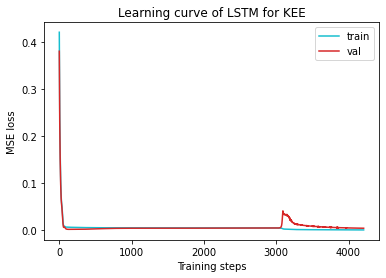

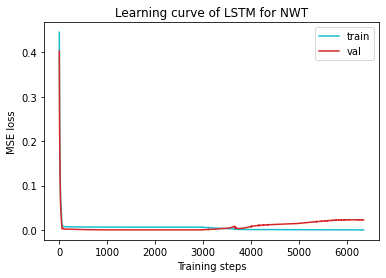

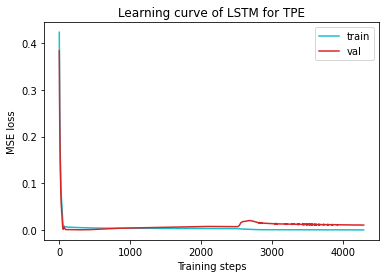

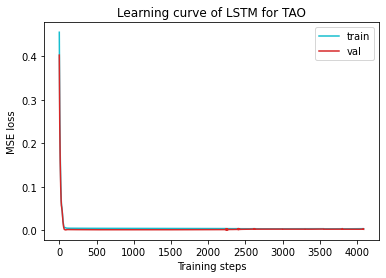

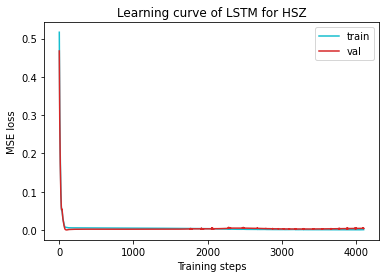

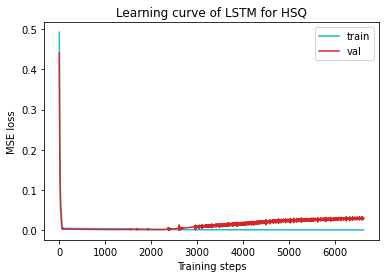

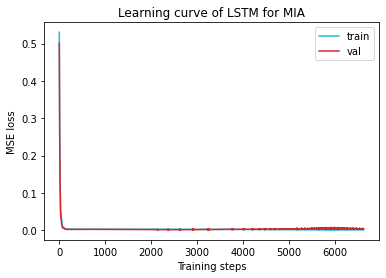

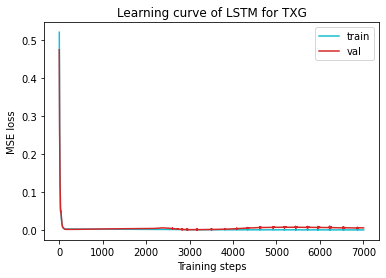

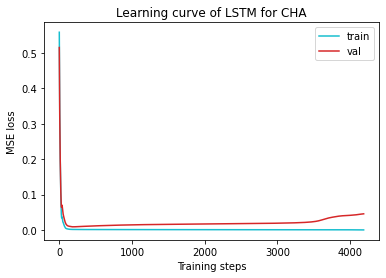

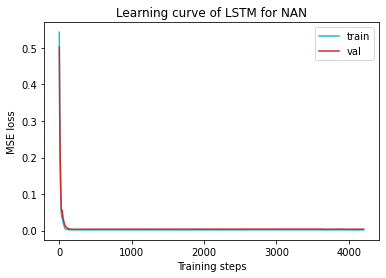

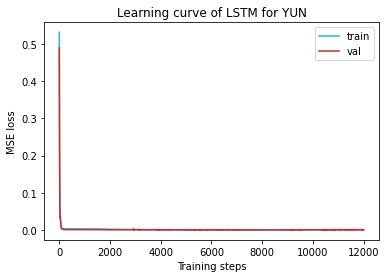

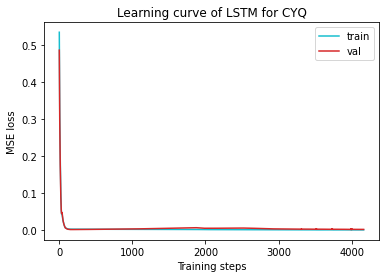

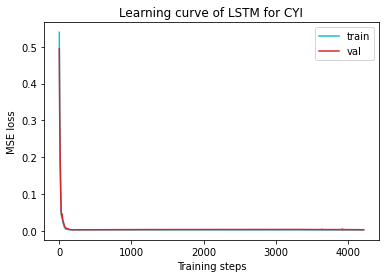

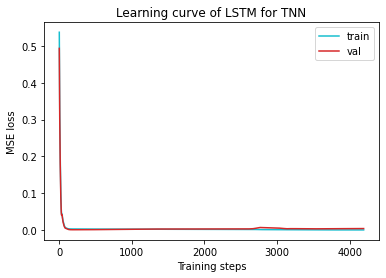

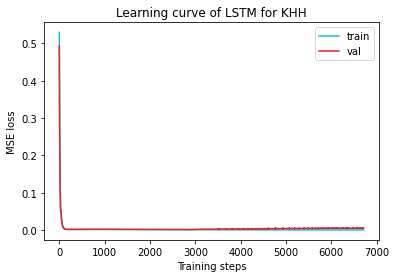

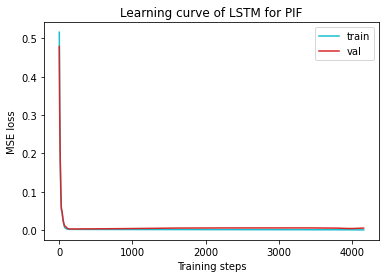

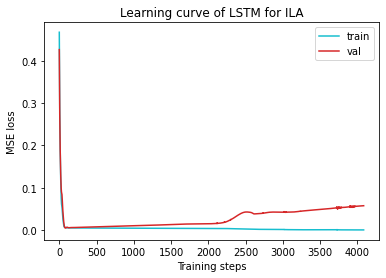

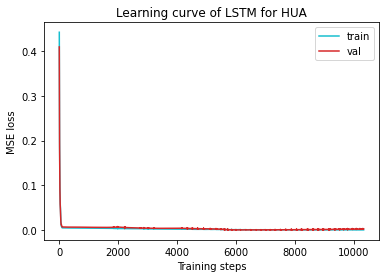

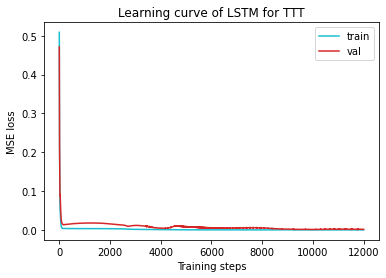

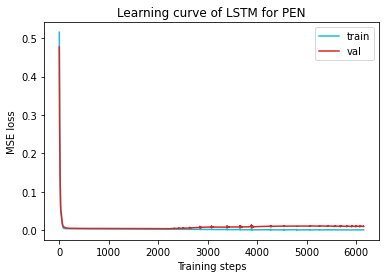

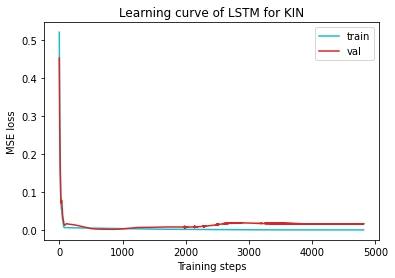

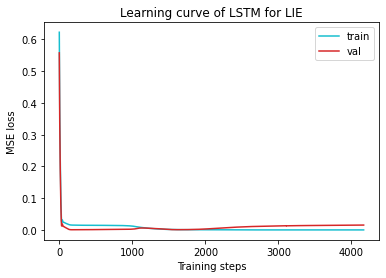

In [ ]:
for city in city_codes:
    total_steps = len(loss_record[city]['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record[city]['train']) // len(loss_record[city]['val'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record[city]['train'], c='tab:cyan', label='train')
    plt.plot(x_2, loss_record[city]['val'], c='tab:red', label='val')
    plt.xlabel("Training steps")
    plt.ylabel("MSE loss")
    plt.title(f"Learning curve of LSTM for {city}")
    plt.legend()
    plt.show()

## **Testing**

Define plotting function.

In [ ]:
def plot_predict(city, data_type, pred, real, start_date):
    plt.plot(pred)
    plt.plot(real)
    plt.suptitle(f"Time-Series Prediction for {city} {data_type}")
    plt.xlabel(f"Time (days) from {start_date}")
    plt.ylabel("Number of New Cases")
    plt.legend(("predicted", "real"))

    if data_type == "Data":
        plt.axvline(x=(train_size-1), c='red', linestyle=':')
    plt.show()

Test for each city and plot it.

In [ ]:
def test(city, model, X, Y):
    model.eval()
    _X, _Y = X.to(device), Y.to(device)
    test_predict = model(_X)
    loss = criterion(test_predict, _Y)

    return test_predict.detach().cpu(), loss.item()

In [ ]:
def printPredError(pred, real):
    # RMSE
    print(f"RMSE: {np.sqrt(np.mean(np.power(pred - real, 2))):.2f}")
    # MAPE
    print(f"MAPE: {np.mean(np.abs(real - pred) / real) * 100:.2f}%")

===== KEE =====
real & predicted test loss: 0.044796655187383294


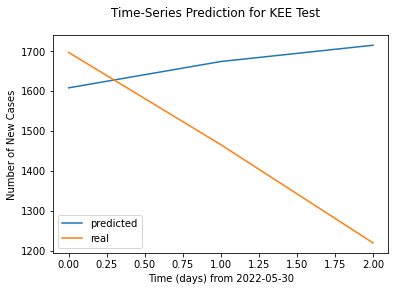

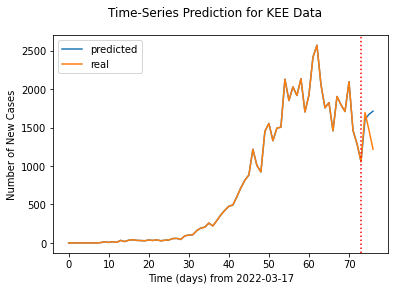

RMSE: 314.29
MAPE: 20.02%
===== NWT =====
real & predicted test loss: 0.06426553236087784


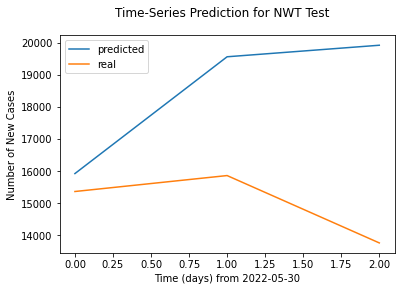

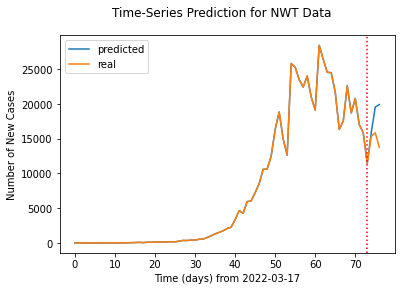

RMSE: 4164.00
MAPE: 23.94%
===== TPE =====
real & predicted test loss: 0.08769243583083153


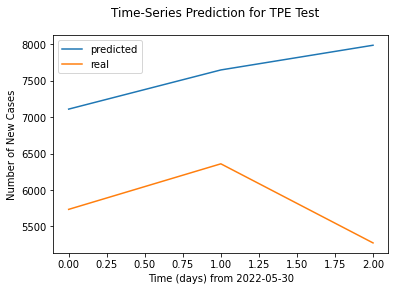

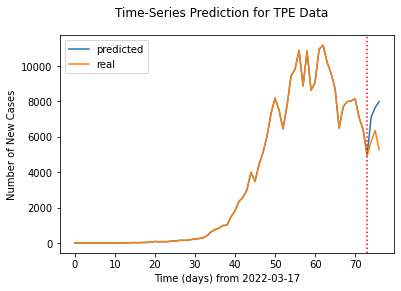

RMSE: 1909.74
MAPE: 31.95%
===== TAO =====
real & predicted test loss: 0.0277544227137696


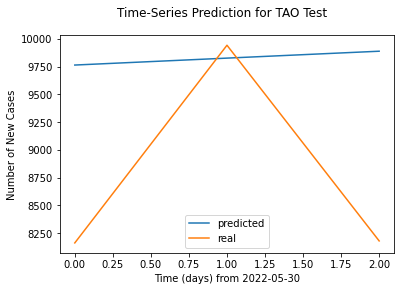

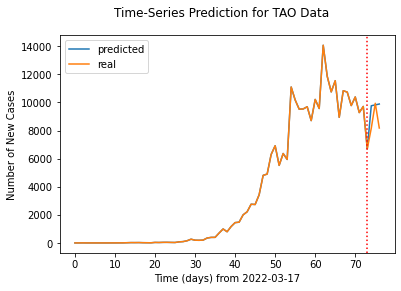

RMSE: 1353.61
MAPE: 13.89%
===== HSZ =====
real & predicted test loss: 0.06761000980623066


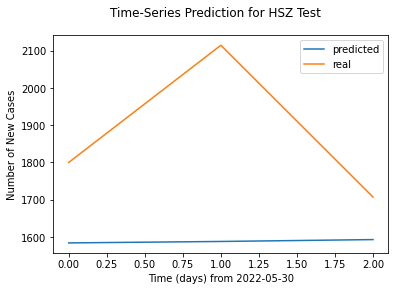

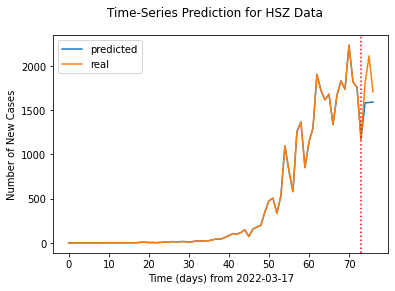

RMSE: 335.52
MAPE: 14.54%
===== HSQ =====
real & predicted test loss: 0.017881462175864726


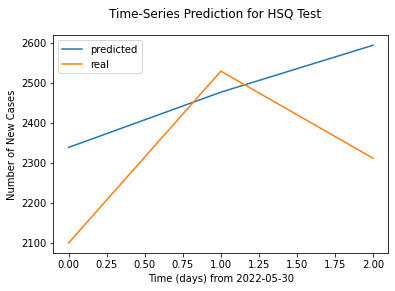

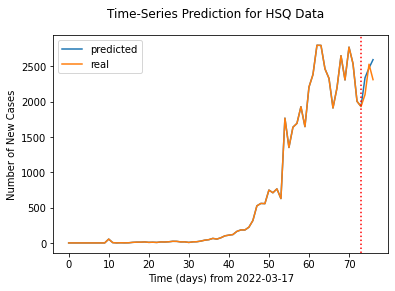

RMSE: 216.02
MAPE: 8.57%
===== MIA =====
real & predicted test loss: 0.027539040790543368


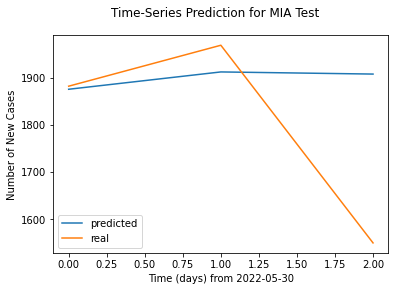

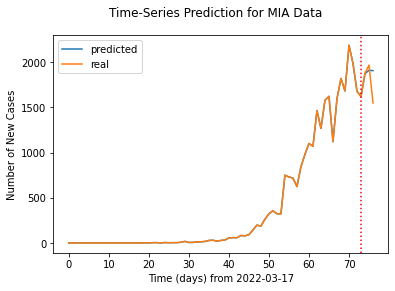

RMSE: 209.73
MAPE: 8.80%
===== TXG =====
real & predicted test loss: 0.35780159942805767


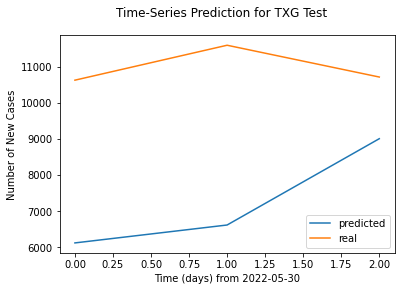

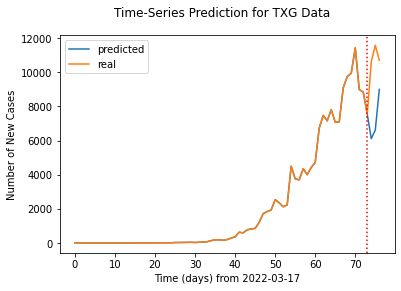

RMSE: 4003.31
MAPE: 33.79%
===== CHA =====
real & predicted test loss: 0.22920036688446999


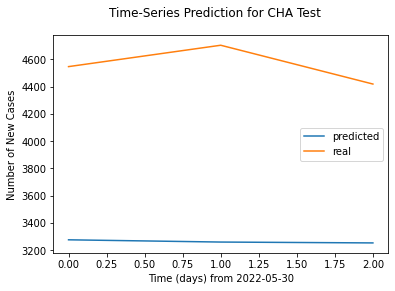

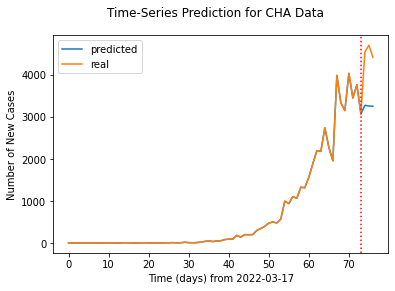

RMSE: 1300.21
MAPE: 28.38%
===== NAN =====
real & predicted test loss: 0.2148241437971592


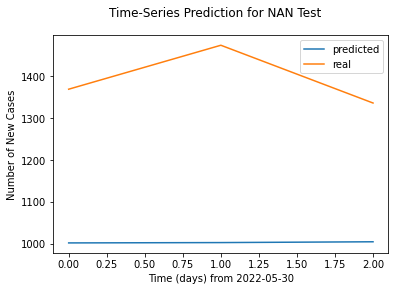

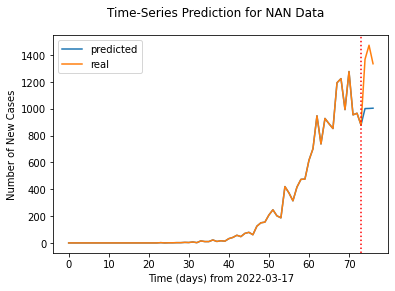

RMSE: 394.44
MAPE: 27.87%
===== YUN =====
real & predicted test loss: 0.1534100966528058


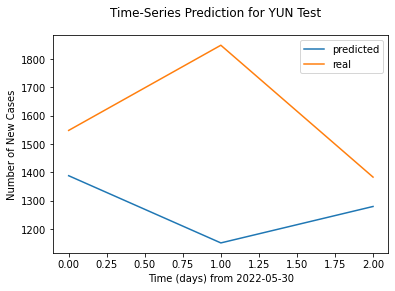

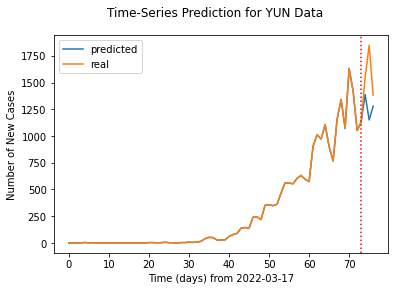

RMSE: 418.12
MAPE: 18.54%
===== CYQ =====
real & predicted test loss: 0.155560702085495


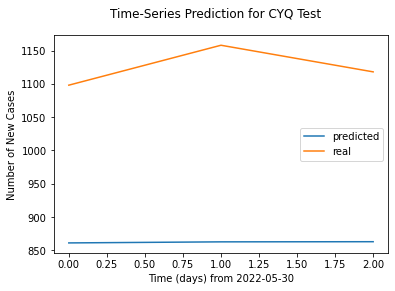

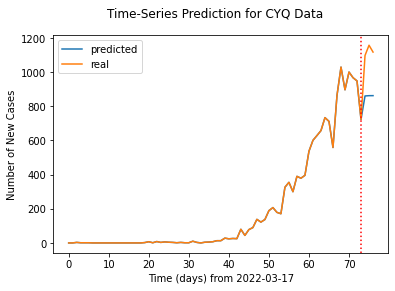

RMSE: 263.69
MAPE: 23.31%
===== CYI =====
real & predicted test loss: 0.30145271867513657


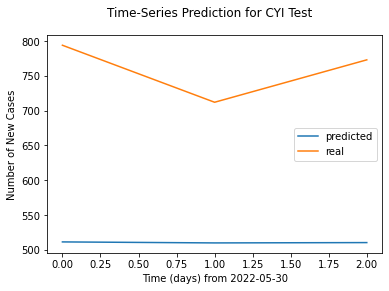

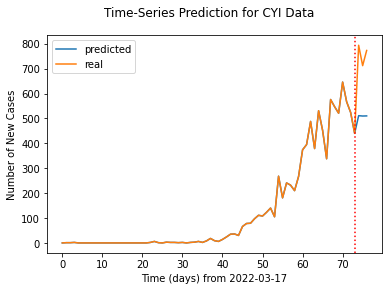

RMSE: 251.69
MAPE: 32.68%
===== TNN =====
real & predicted test loss: 0.08318567671813071


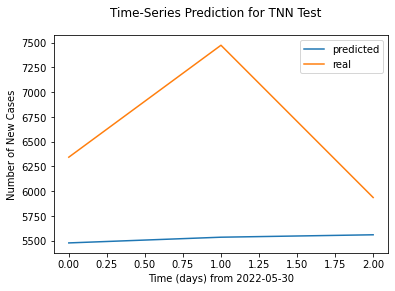

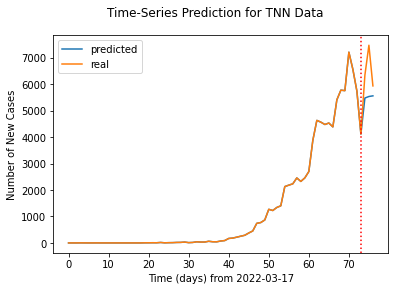

RMSE: 1244.40
MAPE: 15.30%
===== KHH =====
real & predicted test loss: 0.027841399423778057


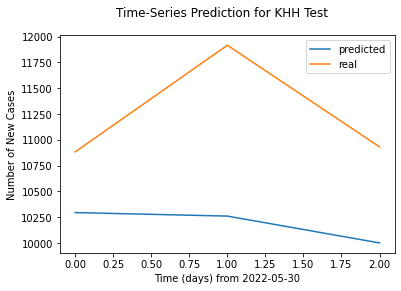

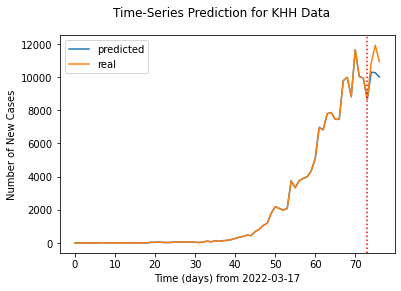

RMSE: 1148.03
MAPE: 9.27%
===== PIF =====
real & predicted test loss: 0.07325957342982292


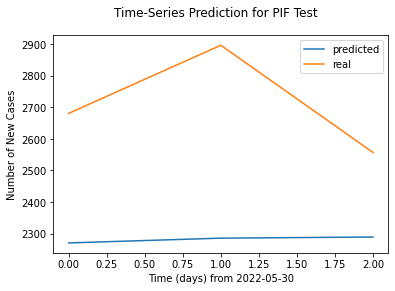

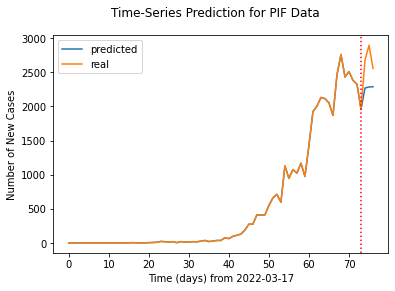

RMSE: 452.71
MAPE: 15.64%
===== ILA =====
real & predicted test loss: 0.013007061152165988


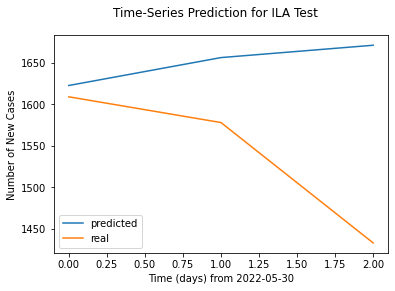

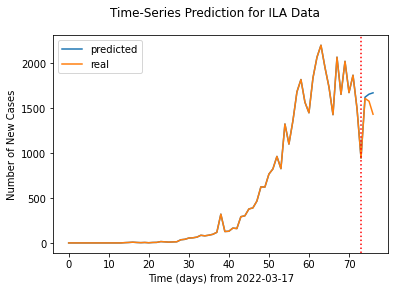

RMSE: 144.93
MAPE: 7.47%
===== HUA =====
real & predicted test loss: 0.02172281965613365


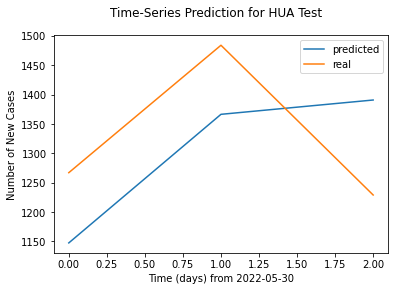

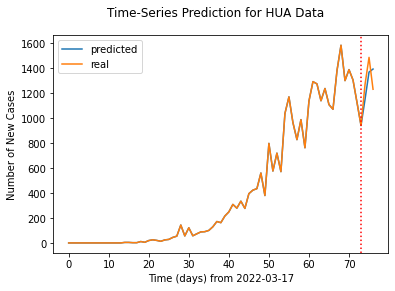

RMSE: 134.53
MAPE: 10.18%
===== TTT =====
real & predicted test loss: 0.08282562403474003


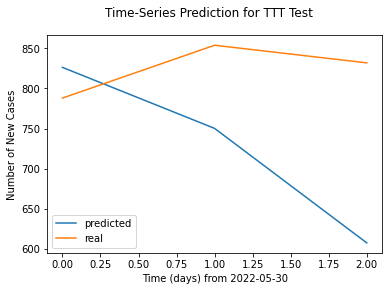

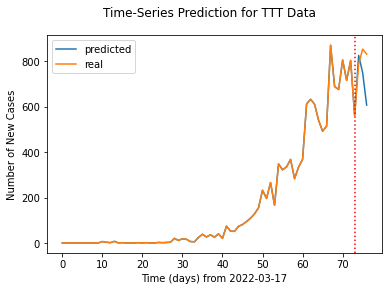

RMSE: 144.72
MAPE: 14.69%
===== PEN =====
real & predicted test loss: 0.21491721272468567


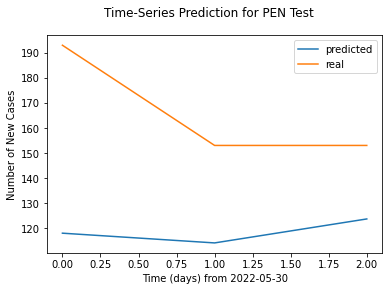

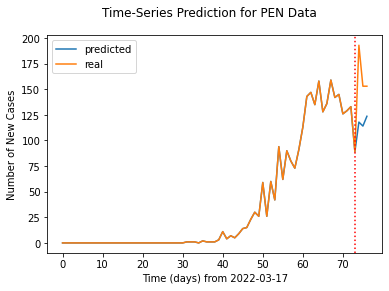

RMSE: 51.66
MAPE: 27.83%
===== KIN =====
real & predicted test loss: 0.06800167029723525


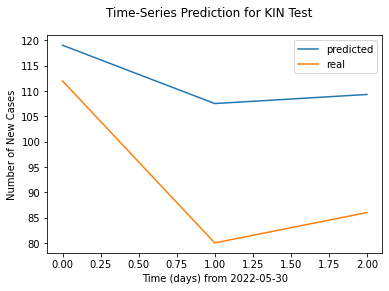

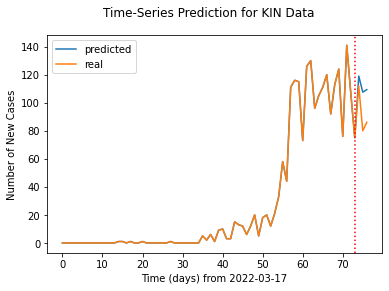

RMSE: 21.23
MAPE: 22.61%
===== LIE =====
real & predicted test loss: 0.11180887604132295


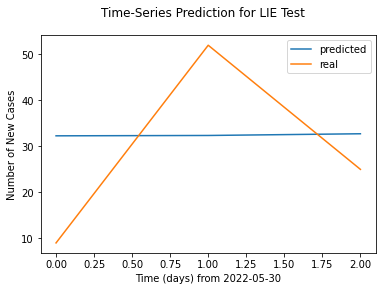

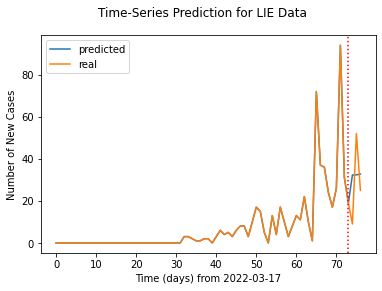

RMSE: 18.15
MAPE: 109.19%


In [ ]:
for city in city_codes:
    print(f"===== {city} =====")
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
    ckpt = torch.load(save_path.format(city), map_location='cpu')
    lstm.load_state_dict(ckpt)

    city_dataset = get_city_data(dataset, city)
    sc, dataX, dataY, _, _, _, _, testX, testY = data_preprocess(city_dataset)
    
    # test set: real & predicted data -> predicted data
    _testX = testX[[0]].clone()
    total_loss = 0
    total_test_predict = []
    for i in range(testY.size(0)):
        test_predict, loss = test(city, lstm, _testX, testY[[i]])
        total_loss += loss
        total_test_predict.append(test_predict)
        _testX = torch.cat((_testX[:,1:], torch.unsqueeze(test_predict, 0)), 1)
    total_test_predict = torch.cat(total_test_predict)

    total_test_predict = sc.inverse_transform(total_test_predict.data.numpy())
    _testY = sc.inverse_transform(testY.data.numpy())
    print(f"real & predicted test loss: {total_loss}")
    plot_predict(city, "Test", total_test_predict, _testY, test_start_date)

    dataY = sc.inverse_transform(dataY.data.numpy())
    _dataY = np.copy(dataY)
    for i in range(testY.size(0)):
        _dataY[-test_size+i][0] = total_test_predict[i][0]
    # print(_dataY)
    plot_predict(city, "Data", _dataY, dataY, start_date_y)
    printPredError(total_test_predict, _testY)

    del lstm

## **Prediction for Long Term**

In [ ]:
def pred_long(model, timeline_x):
    model.eval()
    _timeline_x = timeline_x.to(device)
    pred = model(_timeline_x)

    return pred.detach().cpu()

In [ ]:
def plot_predict_long(city, pred, start_date):
    plt.plot(pred)
    plt.suptitle(f"Time-Series Prediction for {city}")
    plt.xlabel(f"Time (days) from {start_date}")
    plt.ylabel("Number of New Cases")
    plt.legend(("predicted"))
    plt.axvline(x=(train_size-1), c='red', linestyle=':')
    plt.show()

In [ ]:
def save_pred(city, pred):
    with open(f'output/{city}.csv', "w") as out_file:
        out_file.write("new_cases\n")
        np.savetxt(out_file, pred, fmt='%s', delimiter=',')

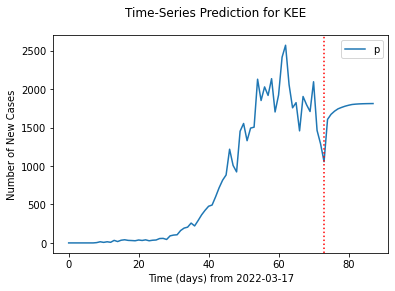

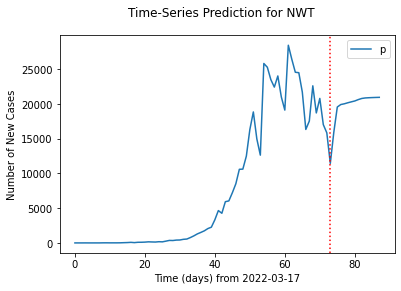

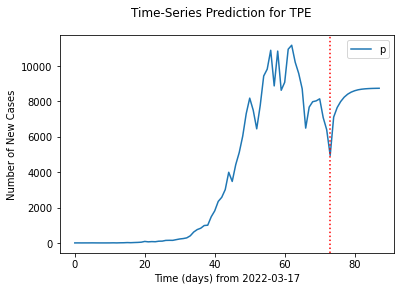

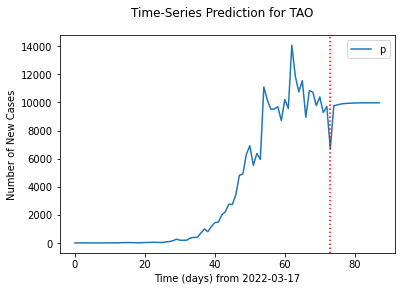

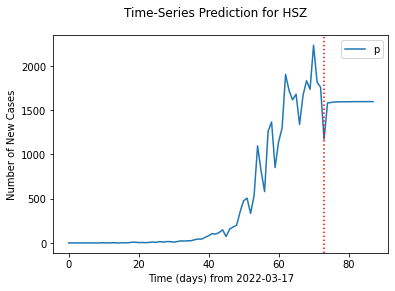

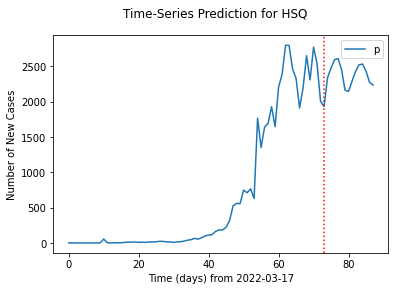

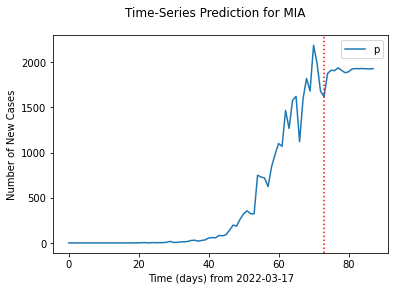

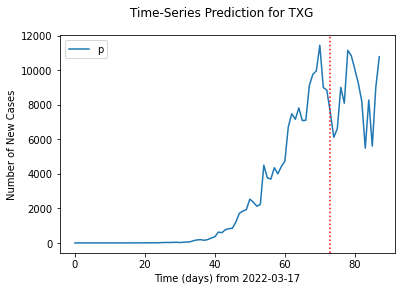

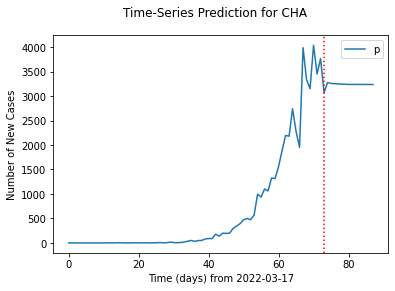

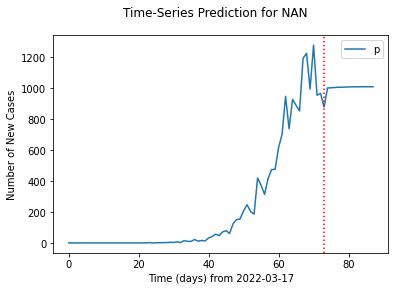

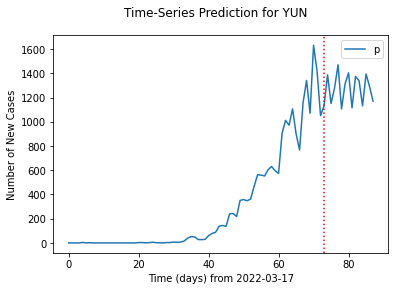

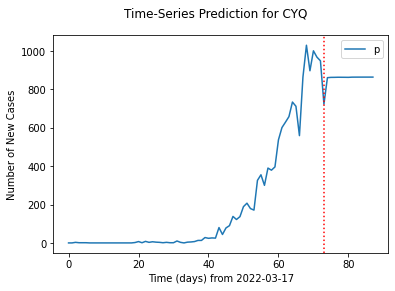

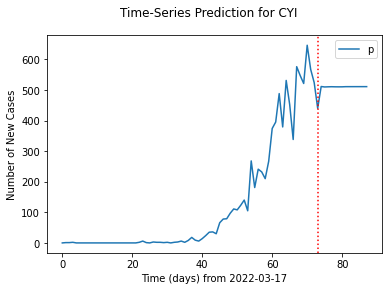

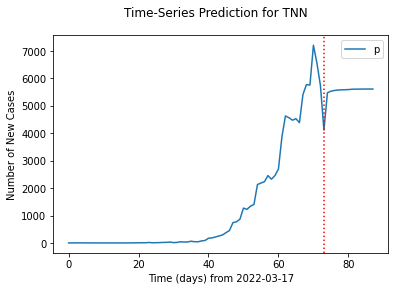

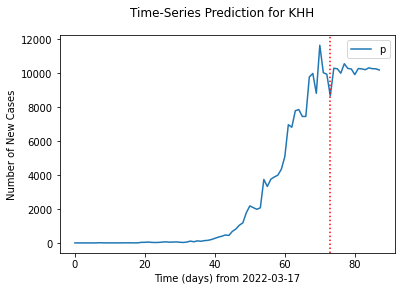

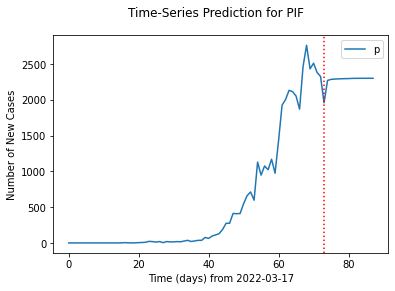

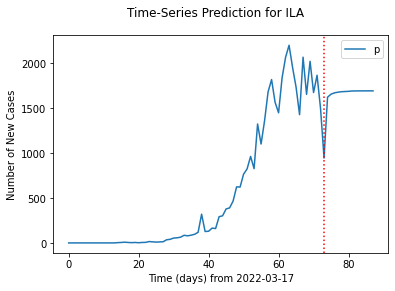

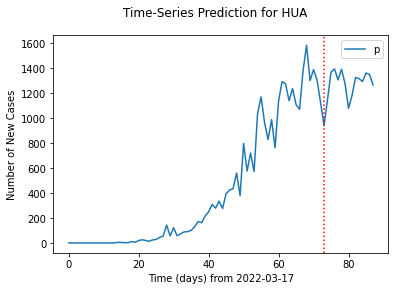

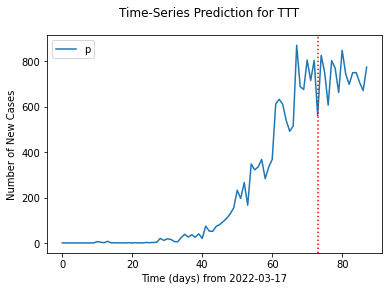

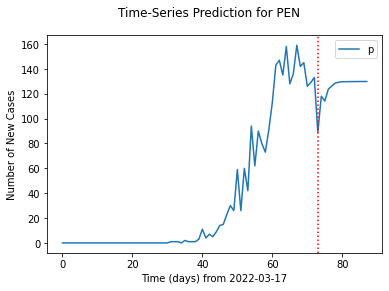

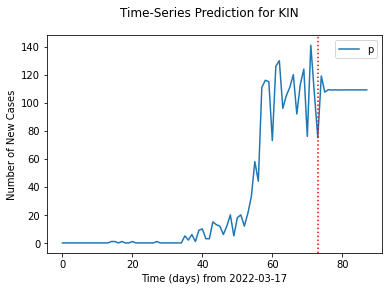

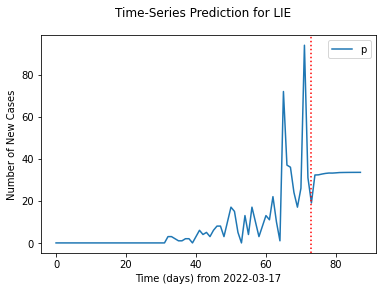

In [ ]:
os.makedirs('output', exist_ok=True)
for city in city_codes:
    lstm = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
    ckpt = torch.load(save_path.format(city), map_location='cpu')
    lstm.load_state_dict(ckpt)

    city_dataset = get_city_data(dataset, city)
    sc, dataX, dataY, _, _, _, _, testX, testY = data_preprocess(city_dataset)

    # test set: real & predicted data -> predicted data
    _testX = testX[[0]].clone()
    total_test_predict = []
    for i in range(pred_long_size):
        test_predict = pred_long(lstm, _testX)
        total_test_predict.append(test_predict)
        _testX = torch.cat((_testX[:,1:], torch.unsqueeze(test_predict, 0)), 1)
    total_test_predict = torch.cat(total_test_predict)


    # with history
    pred_y = np.copy(dataY)
    pred_y = pred_y[:-test_size]
    pred_y = np.append(pred_y, np.zeros((pred_long_size, 1)), 0)
    for i in range(pred_long_size):
        pred_y[-pred_long_size+i][0] = total_test_predict[i][0]
    _pred_y = sc.inverse_transform(pred_y)
    plot_predict_long(city, _pred_y, start_date_y)

    _pred_y = np.rint(_pred_y).astype(int)
    save_pred(city, _pred_y)

    del lstm